In [4]:
import pickle
import PIL, torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from torchvision import models
from torch import nn
import pandas as pd

from load_data import load_et_maps, load_images, load_labels, classes
from load_models import load_mobilenet, load_resnet
from utils import batch_accuracy

if torch.cuda.is_available() == True:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device)
dtype = torch.float32

OCC_ONLY = Path('/home/florian/dev/ET-Adversarials/data/Occ_only_226px/')
IMGS = Path('/home/florian/dev/ET-Adversarials/data/scaled_images/')

torch.cuda.set_per_process_memory_fraction(.2,0)

cuda:0


# Load Data and Model

In [ ]:
img_batch = load_images(IMGS).to(device)
etm_batch = load_et_maps(OCC_ONLY).to(device)
labels = load_labels(IMGS).to(device)

In [8]:
MOBILENET_PATH = './models/MobileNetV3Small.pt'
model = load_mobilenet(MOBILENET_PATH).to(device)
batch_accuracy(model, img_batch, labels)

1.0

## Attacks

### Eye-tracking data aware Carlini Wagner L2 Attack

In [ ]:
def classification_loss(Z,x,t):
    logits = Z(x)[0]
    if logits.argmax() == t:
        loss = torch.nn.functional.relu(logits[logits.argsort(descending=True)[1]] - logits[t])
    else:
        loss = torch.nn.functional.relu(logits[logits.argmax()] - logits[t])
    return loss

def classification_loss(logits,t):
    if logits.argmax() == t:
        loss = torch.nn.functional.relu(logits[logits.argsort(descending=True)[1]] - logits[t])
    else:
        loss = torch.nn.functional.relu(logits[logits.argmax()] - logits[t])
    return loss

'''
    This is the loss term added to the original C&W term. It is the product of delta_i and 
    the eye-tracking-value of pixel i. As such, the loss is high for high delta and eye-tracking values, 
    but low otherwise. Effectively incentivizing the algorithm to find perturbations outside the area 
    humans spend most time when evaluating the image.
'''
def hpa_loss(w,x,et_map):
    delta = 0.5 * (torch.tanh(w) + 1) - x
    return (delta * et_map).norm()

def loss_fn(w,x, logits, et_map, target, verbose=False):
    loss1 = torch.sqrt(torch.norm((.5*(torch.tanh(w) + 1)) - x ))
    loss2 = classification_loss(logits ,target)
    loss3 = hpa_loss(w,x,et_map)
    if verbose == True: print('loss 1:', loss1.item(), ' -- loss 2:',loss2.item(), ' -- loss 3:',loss3.item())
    return loss1, loss2, loss3

def sgd_cw_l2_attack(model, x, et_map, target, loss_fn, iterations, w_initialization='zeros', c=.1,d=.5, lr=10):
    if w_initialization == 'zeros': w = torch.zeros_like(x).requires_grad_(True)
    if w_initialization == 'rand': w = torch.rand_like(x).requires_grad_(True)
    if w_initialization == 'randn': w = (torch.randn_like(x)/4).requires_grad_(True)
    
    stats = pd.DataFrame(columns=['i', 'loss'])
    best_adv = {
        'total-loss':1000
    }
    
    w.requires_grad_(True)
    criterion = loss_fn
    for i in range(iterations):
        if i%50==0:
            print('iteration:', i)
            loss1,loss2,loss3 = criterion(w,x,logits,et_map,target,verbose=True)
        else:
            loss1,loss2,loss3 = criterion(w,x,logits,et_map,target)
        loss = loss1 + c * loss2 + d * loss3
#       print(loss)
        loss.backward(retain_graph=True)
        if loss < best_adv['total-loss']:
            best_adv = {
                'l2-loss': loss1,
                'classification-loss': loss2,
                'human-perception-loss': loss3,
                'total-loss':loss,
                'adv': .5 * (torch.tanh(w)+1),
                'w': w,
                'iteration': i,
                'prediction':model(.5 * (torch.tanh(w)+1).unsqueeze(0)).argmax()
            }
        grads = w.grad
        w = w - lr * grads
        w.retain_grad()
        stats = stats.append(pd.Series({'i':i, 'loss':loss.item()}), ignore_index=True)
        
    return best_adv, stats

def pt_optim_cw_l2_attack(model, x, et_map, target, loss_fn, iterations, w_initialization='zeros', C=[1e-4,1e-3,1e-2,1e-1,1] ,D=[0.05,.1,.5], optim=torch.optim.Adam, lr=.01, verbose=False):
    if w_initialization == 'zeros': w = torch.zeros_like(x).requires_grad_(True)
    if w_initialization == 'rand': w = torch.rand_like(x).requires_grad_(True)
    if w_initialization == 'randn': w = (torch.randn_like(x)/4).requires_grad_(True)
    stats = pd.DataFrame(columns=['i', 'loss'])
    best_adv = {
        'total-loss':1000
    }
    w.requires_grad_(True)
    
    optimizer = optim([w],lr=lr)
    criterion = loss_fn
    
    for c in C:
        for d in D:
            for i in range(iterations):
                optimizer.zero_grad()
                adv = .5 * (torch.tanh(w)+1)
                logits = model(adv.unsqueeze(0))[0]
                pred = logits.argmax(-1)
                #print(target)
                if verbose==True and i%200==0: print('iteration:', i)
                loss1,loss2,loss3 = criterion(w,x,logits,et_map,target,verbose=verbose)
                loss = loss1 + c * loss2 + d * loss3
        #       print(loss)
                
                if loss1+10*loss2+loss3 < best_adv['total-loss'] and pred==target:
                    best_adv = {
                        'l2-loss': loss1,
                        'classification-loss': loss2,
                        'human-perception-loss': loss3,
                        'total-loss':loss1+10*loss2+loss3,
                        'adv': adv,
                        'c': c,
                        'd': d,
                        'w': w,
                        'iteration': i,
                        'prediction':pred
                    }
                loss.backward(retain_graph=True)
                optimizer.step()
                stats = stats.append(pd.Series({'i':i, 'loss':loss.item()}), ignore_index=True)
        c = c*10
    return best_adv, stats


def get_targets(model, img_batch, gt_labels):
    targets = list()
    logits = model(img_batch)
    for i,pred in enumerate(logits):
        if pred.argmax()==gt_labels[i]:
            targets.append(pred.argsort(descending=True)[1])
        else: targets.append(pred.argmax())
    return(torch.Tensor(targets))

targets = get_targets(model, img_batch.to(device), labels)

x = img_batch[0]
et_map = etm_batch[0]

# Single Attack

In [ ]:
pt_sgd_best_adv,_ = pt_optim_cw_l2_attack(
    model, x,et_map,0, loss_fn, 3000, w_initialization='zeros', optim=torch.optim.SGD, lr=10
)

pt_adam_best_adv,_ = pt_optim_cw_l2_attack(
    model, x,et_map,3, loss_fn, 5000, w_initialization='zeros', optim=torch.optim.Adam, lr=.01
)

sgd_best_adv,_ = sgd_cw_l2_attack(
    model, x,et_map,0, loss_fn, 5000, w_initialization='zeros', lr=10
)

In [105]:
sgd_best_adv['iteration'], pt_sgd_best_adv['iteration'], pt_adam_best_adv['iteration']

(2936, 497, 3964)

In [99]:
sgd_adv = sgd_best_adv['adv']
sgd_delta = (sgd_adv-x)*50+.5
pt_sgd_adv = pt_sgd_best_adv['adv']
pt_sgd_delta = (pt_sgd_adv-x)*50+.5
pt_adam_adv = pt_adam_best_adv['adv']
pt_adam_delta = (pt_adam_adv-x)*50+.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'l2-loss: 1.02996027469635| hp-loss: 0.1961529552936554')

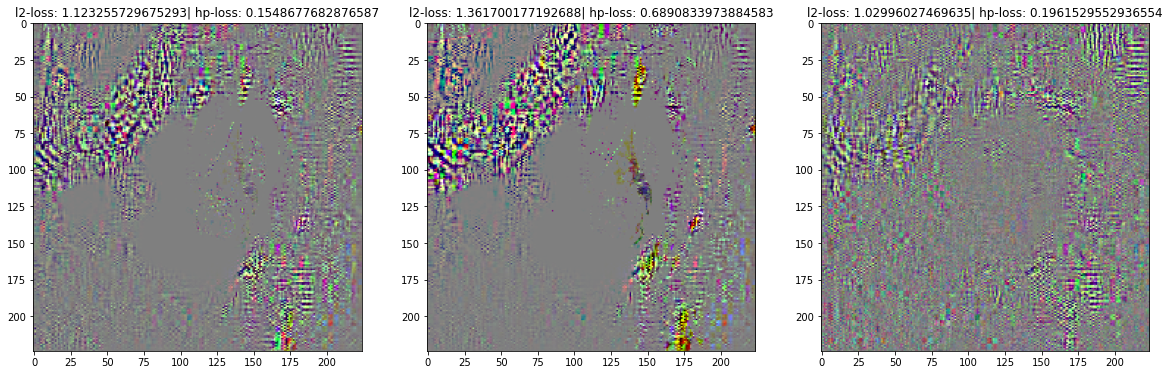

In [101]:
fig, axes = plt.subplots(1,4, figsize=(20,10))
axes = axes.flatten()
axes[0].imshow(et_map.detach().cpu().squeeze())
axes[1].imshow(sgd_delta.detach().cpu().permute(1,2,0))
axes[1].set_title('l2-loss: '+str(sgd_best_adv['l2-loss'].item()) + '| hp-loss: ' +str(sgd_best_adv['human-perception-loss'].item()))
axes[2].imshow(pt_sgd_delta.detach().cpu().permute(1,2,0))
axes[2].set_title('l2-loss: '+str(pt_sgd_best_adv['l2-loss'].item()) + '| hp-loss: ' +str(pt_sgd_best_adv['human-perception-loss'].item()))
axes[3].imshow(pt_adam_delta.detach().cpu().permute(1,2,0))
axes[3].set_title('l2-loss: '+str(pt_adam_best_adv['l2-loss'].item()) + '| hp-loss: ' +str(pt_adam_best_adv['human-perception-loss'].item()))

# Batch attack

In [23]:
C = [1e-4 * 10** x for x in range(9)]
targets = get_targets(model, img_batch, labels).int()
advs = []
for i, (x,et_map,target) in enumerate(zip(img_batch, etm_batch, targets)):
    print('----------', i,'---------')
    best_adv,_ = pt_optim_cw_l2_attack(
        model, 
        x,
        et_map,
        target, 
        loss_fn=loss_fn, 
        iterations=10000, 
        C=C,
        lr=.01
    )
    advs.append(best_adv)

    with open('et-aware-advs-w-fb-params.pkl', 'wb') as handle:
        pickle.dump(advs, handle, protocol=pickle.HIGHEST_PROTOCOL)

---------- 0 ---------
---------- 1 ---------
---------- 2 ---------
---------- 3 ---------
---------- 4 ---------
---------- 5 ---------
---------- 6 ---------
---------- 7 ---------
---------- 8 ---------
---------- 9 ---------
---------- 10 ---------
---------- 11 ---------
---------- 12 ---------
---------- 13 ---------
---------- 14 ---------
---------- 15 ---------
---------- 16 ---------
---------- 17 ---------
---------- 18 ---------
---------- 19 ---------
---------- 20 ---------
---------- 21 ---------
---------- 22 ---------
---------- 23 ---------
---------- 24 ---------
---------- 25 ---------
---------- 26 ---------
---------- 27 ---------
---------- 28 ---------
---------- 29 ---------
---------- 30 ---------
---------- 31 ---------
---------- 32 ---------
---------- 33 ---------
---------- 34 ---------
---------- 35 ---------
---------- 36 ---------
---------- 37 ---------
---------- 38 ---------
---------- 39 ---------
---------- 40 ---------
---------- 41 ---------
--

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 10.75 GiB total capacity; 1.27 GiB already allocated; 6.38 MiB free; 2.15 GiB allowed; 1.31 GiB reserved in total by PyTorch)